<a href="https://colab.research.google.com/github/jonkrohn/ML-foundations/blob/master/notebooks/regression-in-pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression in PyTorch

In this notebook, we use the PyTorch **automatic differentiation** library to fit a straight line to data points. Thus, here we use calculus to solve the same regression problem that we used the Moore-Penrose Pseudoinverse to solve in the [*Linear Algebra II* notebook](https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/2-linear-algebra-ii.ipynb).

In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
x = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7.]) # dosage of Alzheimer's drug
x

tensor([0., 1., 2., 3., 4., 5., 6., 7.])

The $y$ values were created using the equation of a line $y = mx + b$. This way, we know what the model parameters to be learned are, say, $m = -0.5$ and $b = 2$. Random, normally-distributed noise has been added to simulate sampling error: 

In [3]:
# y = -0.5*x + 2 + np.random.normal(scale=0.2, size=8).reshape(-1,1)
## For reproducibility, here's a fixed example of y values obtained by 
## running the commented-out line above (N.B. you'd need 'import numpy as np'):
y = torch.tensor([1.86, 1.31, .62, .33, .09, -.67, -1.23, -1.37]) # forgetfulness score
y

tensor([ 1.8600,  1.3100,  0.6200,  0.3300,  0.0900, -0.6700, -1.2300, -1.3700])

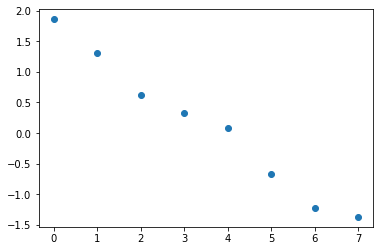

In [4]:
fig, ax = plt.subplots()
_ = ax.scatter(x, y)

Initialize the slope parameter $m$ with a "random" value of 0.9...

In [5]:
m = torch.tensor([0.9]).requires_grad_()
m

tensor([0.9000], requires_grad=True)

...and do the same for the $y$-intercept parameter $b$: 

In [6]:
b = torch.tensor([0.1]).requires_grad_()
b

tensor([0.1000], requires_grad=True)

In [7]:
def regression_plot(my_x, my_y, my_m, my_b):
    
    fig, ax = plt.subplots()

    ax.scatter(my_x, my_y)
    x_min, x_max = ax.get_xlim()
    y_min, y_max = my_b, my_b + my_m*(x_max-x_min)

    ax.plot([x_min, x_max], [y_min, y_max])
    _ = ax.set_xlim([x_min, x_max])

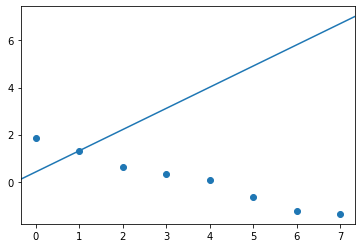

In [8]:
regression_plot(x, y, m, b)

In [9]:
def regression(my_x, my_m, my_b):
    return my_x*my_m + my_b

**Return to slides here if following *Calculus I* class.**

### Machine Learning
In four easy steps :)

**Step 1**: Forward pass

In [10]:
yhat = regression(x, m, b)
yhat

tensor([0.1000, 1.0000, 1.9000, 2.8000, 3.7000, 4.6000, 5.5000, 6.4000],
       grad_fn=<AddBackward0>)

**Step 2**: Compare $\hat{y}$ with true $y$ to calculate cost $C$

There is a PyTorch `MSELoss` method, but let's define it outselves to see how it works. MSE cost is defined by: $$C = \frac{1}{n} \sum_{i=1}^n (\hat{y_i}-y_i)^2 $$

In [11]:
def mse(my_yhat, my_y): 
    sigma = torch.sum((my_yhat - my_y)**2)
    return sigma/len(my_y)

In [12]:
C = mse(yhat, y)
C

tensor(19.6755, grad_fn=<DivBackward0>)

**Step 3**: Use autodiff to calculate gradient of $C$ w.r.t. parameters

In [13]:
C.backward()

In [14]:
m.grad

tensor([36.3050])

In [15]:
b.grad

tensor([6.2650])

**Step 4**: Gradient descent

In [16]:
optimizer = torch.optim.SGD([m, b], lr=0.01)

In [17]:
optimizer.step()

Confirm parameters have been adjusted sensibly: 

In [18]:
m

tensor([0.5369], requires_grad=True)

In [19]:
b

tensor([0.0374], requires_grad=True)

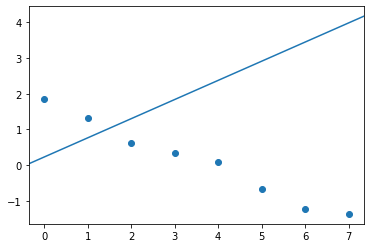

In [20]:
regression_plot(x, y, m, b)

We can repeat steps 1 and 2 to confirm cost has decreased: 

In [21]:
C = mse(regression(x, m, b), y)
C

tensor(8.5722, grad_fn=<DivBackward0>)

Put the 4 steps in a loop to iteratively minimize cost toward zero: 

In [22]:
epochs = 1000
for epoch in range(epochs):
    
    optimizer.zero_grad() # Reset gradients to zero; else they accumulate
    
    yhat = regression(x, m, b) # Step 1
    C = mse(yhat, y) # Step 2
    
    C.backward() # Step 3
    optimizer.step() # Step 4
    
    print('Epoch {}, cost {}, m grad {}, b grad {}'.format(epoch, '%.3g' % C.item(), '%.3g' % m.grad.item(), '%.3g' % b.grad.item()))

Epoch 0, cost 8.57, m grad 23.2, b grad 3.6
Epoch 1, cost 4.08, m grad 14.8, b grad 1.91
Epoch 2, cost 2.25, m grad 9.49, b grad 0.831
Epoch 3, cost 1.51, m grad 6.11, b grad 0.15
Epoch 4, cost 1.2, m grad 3.96, b grad -0.28
Epoch 5, cost 1.07, m grad 2.59, b grad -0.552
Epoch 6, cost 1.01, m grad 1.72, b grad -0.723
Epoch 7, cost 0.981, m grad 1.17, b grad -0.829
Epoch 8, cost 0.962, m grad 0.82, b grad -0.894
Epoch 9, cost 0.948, m grad 0.595, b grad -0.934
Epoch 10, cost 0.936, m grad 0.452, b grad -0.957
Epoch 11, cost 0.925, m grad 0.361, b grad -0.969
Epoch 12, cost 0.915, m grad 0.302, b grad -0.975
Epoch 13, cost 0.904, m grad 0.265, b grad -0.977
Epoch 14, cost 0.894, m grad 0.241, b grad -0.976
Epoch 15, cost 0.884, m grad 0.225, b grad -0.973
Epoch 16, cost 0.874, m grad 0.214, b grad -0.969
Epoch 17, cost 0.864, m grad 0.207, b grad -0.965
Epoch 18, cost 0.854, m grad 0.202, b grad -0.96
Epoch 19, cost 0.845, m grad 0.199, b grad -0.955
Epoch 20, cost 0.835, m grad 0.196, b

Epoch 406, cost 0.0289, m grad 0.0207, b grad -0.102
Epoch 407, cost 0.0288, m grad 0.0206, b grad -0.101
Epoch 408, cost 0.0286, m grad 0.0205, b grad -0.101
Epoch 409, cost 0.0285, m grad 0.0204, b grad -0.1
Epoch 410, cost 0.0284, m grad 0.0203, b grad -0.0997
Epoch 411, cost 0.0283, m grad 0.0202, b grad -0.0991
Epoch 412, cost 0.0282, m grad 0.02, b grad -0.0985
Epoch 413, cost 0.0281, m grad 0.0199, b grad -0.098
Epoch 414, cost 0.028, m grad 0.0198, b grad -0.0974
Epoch 415, cost 0.0279, m grad 0.0197, b grad -0.0968
Epoch 416, cost 0.0278, m grad 0.0196, b grad -0.0963
Epoch 417, cost 0.0277, m grad 0.0195, b grad -0.0957
Epoch 418, cost 0.0276, m grad 0.0194, b grad -0.0952
Epoch 419, cost 0.0276, m grad 0.0192, b grad -0.0946
Epoch 420, cost 0.0275, m grad 0.0191, b grad -0.0941
Epoch 421, cost 0.0274, m grad 0.019, b grad -0.0935
Epoch 422, cost 0.0273, m grad 0.0189, b grad -0.093
Epoch 423, cost 0.0272, m grad 0.0188, b grad -0.0925
Epoch 424, cost 0.0271, m grad 0.0187, b

Epoch 716, cost 0.0197, m grad 0.00345, b grad -0.017
Epoch 717, cost 0.0197, m grad 0.00343, b grad -0.0169
Epoch 718, cost 0.0197, m grad 0.00341, b grad -0.0168
Epoch 719, cost 0.0197, m grad 0.0034, b grad -0.0167
Epoch 720, cost 0.0197, m grad 0.00338, b grad -0.0166
Epoch 721, cost 0.0197, m grad 0.00336, b grad -0.0165
Epoch 722, cost 0.0197, m grad 0.00334, b grad -0.0164
Epoch 723, cost 0.0197, m grad 0.00332, b grad -0.0163
Epoch 724, cost 0.0197, m grad 0.0033, b grad -0.0162
Epoch 725, cost 0.0197, m grad 0.00328, b grad -0.0161
Epoch 726, cost 0.0197, m grad 0.00326, b grad -0.016
Epoch 727, cost 0.0197, m grad 0.00324, b grad -0.0159
Epoch 728, cost 0.0197, m grad 0.00322, b grad -0.0159
Epoch 729, cost 0.0197, m grad 0.00321, b grad -0.0158
Epoch 730, cost 0.0197, m grad 0.00319, b grad -0.0157
Epoch 731, cost 0.0197, m grad 0.00317, b grad -0.0156
Epoch 732, cost 0.0197, m grad 0.00315, b grad -0.0155
Epoch 733, cost 0.0197, m grad 0.00313, b grad -0.0154
Epoch 734, cos

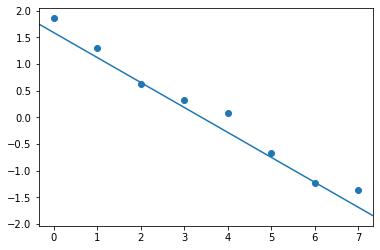

In [23]:
regression_plot(x, y, m, b)